In [50]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 
from torch.utils.data import DataLoader

In [51]:
# Import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris')

# Organize the data

# Convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# Transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

# Break the data into batches

In [52]:
# Separate the data into DataLoaders
# Use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

# Then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)
test_dataset = torch.utils.data.TensorDataset(test_data, test_labels)

# Finally, translate into dataloader objects
batch_size = 64
# int(train_data.tensors[0].shape[0]/4) -- Hard-coding is better to avoid huge batches!
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=test_dataset.tensors[0].shape[0])

# Specify the model architecture and training plan

In [53]:
def create_a_new_model(L1_lambda):
  # Model architecture
  ANN_iris = nn.Sequential(
    nn.Linear(4, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 3)
  )

  # Loss Function
  loss_func = nn.CrossEntropyLoss()

  # Optimizer
  optimizer = torch.optim.SGD(params=ANN_iris.parameters(), lr=0.0005)

  return ANN_iris, loss_func, optimizer

In [54]:
# Explore the model in more detail
temp_model = create_a_new_model(L1_lambda=0)[0]

# Print the model architecture
print(temp_model)

# Print the model's parameters
for i in temp_model.named_parameters():
  print(i[0], ' | ', i[1].shape, ' | ', i[1].numel(), '\n')

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=3, bias=True)
)
0.weight  |  torch.Size([64, 4])  |  256 

0.bias  |  torch.Size([64])  |  64 

2.weight  |  torch.Size([64, 64])  |  4096 

2.bias  |  torch.Size([64])  |  64 

4.weight  |  torch.Size([3, 64])  |  192 

4.bias  |  torch.Size([3])  |  3 



# Function that trains the model

In [55]:
# Global parameter
num_epochs = 1000

def train_the_model(L1_lambda, ANN_model, loss_func, optimizer):
  # Initialize accuracies as empties
  train_acc = []
  test_acc = []
  losses = []

  # Count the total number of weights in the model
  n_weights = 0
  for param_name, weight in ANN_model.named_parameters():
    if ('bias' not in param_name):
      n_weights += weight.numel()

  # Loop over epochs
  for epoch_i in range(num_epochs):

    # Loop over training data batches
    batch_acc = []
    batch_loss = []

    for X, y in train_loader:

      # Forward pass and loss
      y_hat = ANN_model(X)
      loss = loss_func(y_hat, y)

      # Initialize l1 term
      L1_term = torch.tensor(0.)

      # Sum up all abs(weights)
      for param_name, weight in ANN_model.named_parameters():
        if ('bias' not in param_name):
          L1_term += torch.sum(torch.abs(weight))

      # Add to loss term
      loss += L1_lambda * L1_term / n_weights

      # Backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      # Compute training accuracy just for this batch
      batch_acc.append(100 * torch.mean(((torch.argmax(y_hat, axis=1)) == y).float()).item())
      batch_loss.append(loss.item())
    # End of batch loop...

    # Now that we've trained through the batches, get their average training accuracy
    train_acc.append(np.mean(batch_acc))
    losses.append(np.mean(batch_loss))

    # Test accuracy
    # Extract x,y from test dataloader
    X, y = next(iter(test_loader))
    y_hat = ANN_model(X)
    test_acc.append(100 * torch.mean(((torch.argmax(y_hat, axis=1)) == y).float()).item())
  
  # Function output
  return train_acc, test_acc, losses

# Bring it to life!

In [56]:
# Create a model
ANN_iris, loss_func, optimizer = create_a_new_model(L1_lambda=0.001)

# Train the model
L1_lambda = 0.001
train_acc, test_acc, losses = train_the_model(L1_lambda=L1_lambda, ANN_model=ANN_iris, 
                                            loss_func=loss_func, optimizer=optimizer)

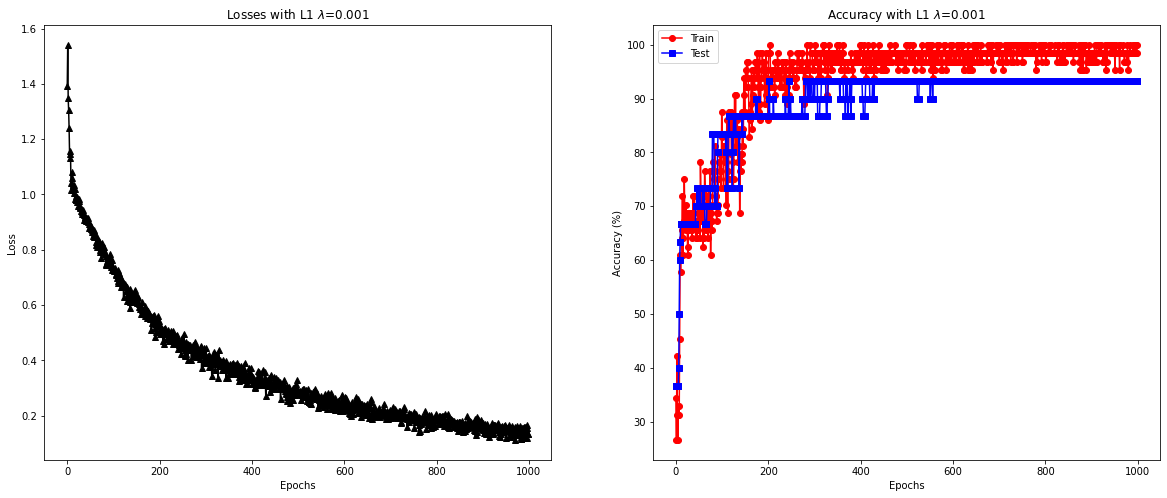

In [57]:
# Plot the results
fig,ax = plt.subplots(1, 2, figsize=(20, 8))

ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with L1 $\lambda$=' + str(L1_lambda))

ax[1].plot(train_acc,'ro-')
ax[1].plot(test_acc,'bs-')
ax[1].set_title('Accuracy with L1 $\lambda$=' + str(L1_lambda))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])

plt.show()

In [58]:
# Create a 1D smoothing filter
def smooth(x, k):
  return np.convolve(a=x, v=np.ones(k) / k, mode='same')

# Now for the parameteric experiment

In [59]:
# Range of L1 regularization amounts
L1_lambdas = np.linspace(start=0, stop=0.005, num=10)

# Initialize output results matrices
accuracy_results_train = np.zeros(shape=(num_epochs, len(L1_lambdas)))
accuracy_results_test = np.zeros(shape=(num_epochs, len(L1_lambdas)))

# Loop over batch sizes
for L1_lambda_i in range(len(L1_lambdas)):

  # Create and train a model
  ANN_iris, loss_func, optimizer = create_a_new_model(L1_lambda=L1_lambdas[L1_lambda_i])
  train_acc, test_acc, losses = train_the_model(ANN_model=ANN_iris, 
                                                L1_lambda=L1_lambdas[L1_lambda_i], 
                                                loss_func=loss_func, optimizer=optimizer)
  
  # Store data
  accuracy_results_train[:, L1_lambda_i] = smooth(train_acc, k=10)
  accuracy_results_test[:, L1_lambda_i] = smooth(test_acc, k=10)

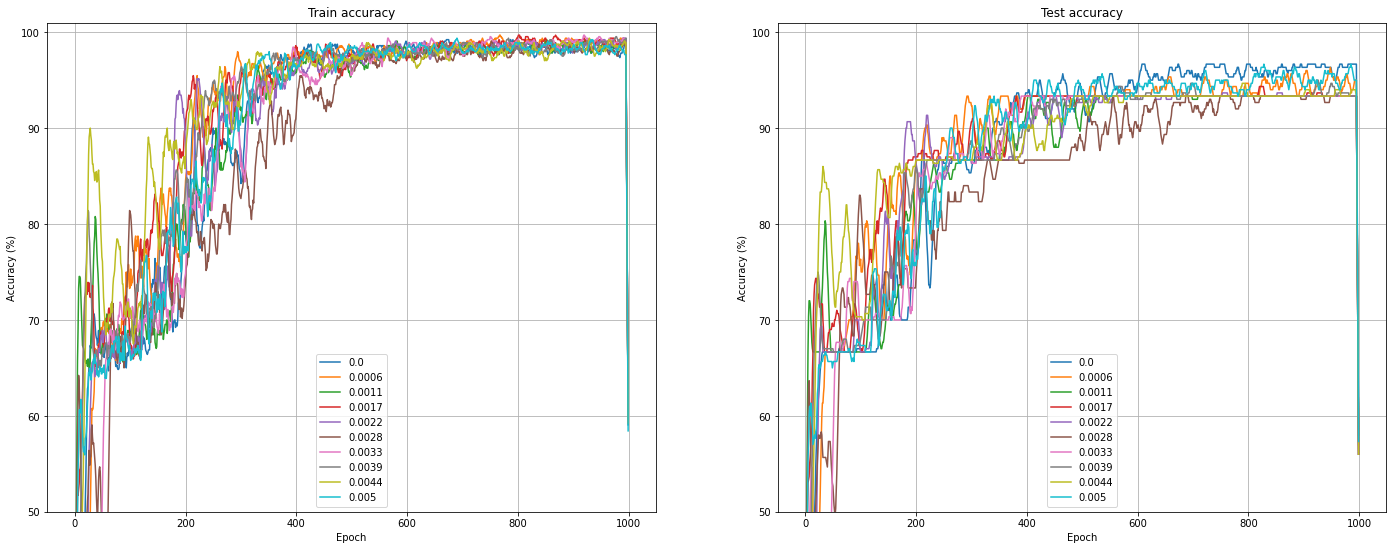

In [60]:
# Plot some results
fig,ax = plt.subplots(1, 2, figsize=(24, 9))

ax[0].plot(accuracy_results_train)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracy_results_test)
ax[1].set_title('Test accuracy')

# Make the legend easier to read
leg_labels = [np.round(i,4) for i in L1_lambdas]

# Common features
for i in range(2):
  ax[i].legend(leg_labels)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,101])
  ax[i].grid()

plt.show()

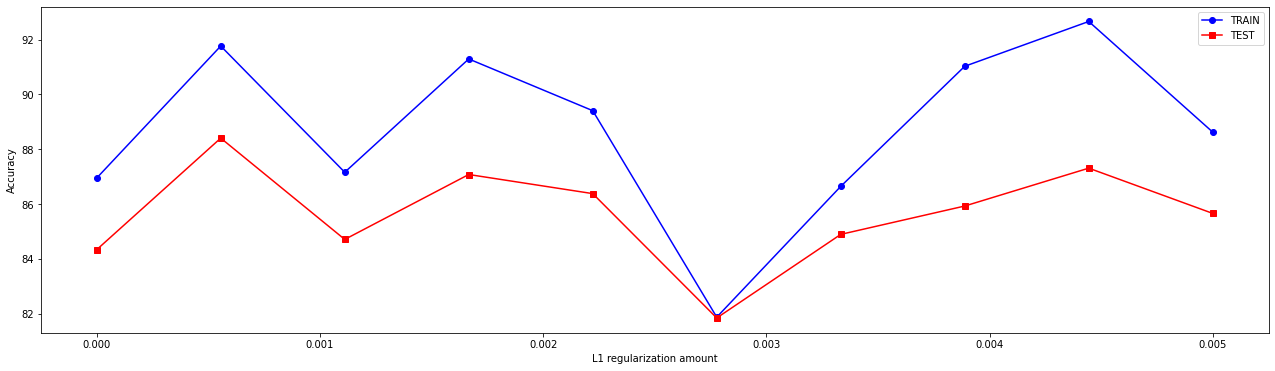

In [61]:
# Show average accuracy by L1 rate

# Average only some epochs
epoch_range = [160, 390]
plt.figure(figsize=(22, 6))
plt.plot(L1_lambdas, 
        np.mean(accuracy_results_train[epoch_range[0]:epoch_range[1], :], axis=0),
        'bo-', label='TRAIN')

plt.plot(L1_lambdas, 
        np.mean(accuracy_results_test[epoch_range[0]:epoch_range[1], :], axis=0),
        'rs-', label='TEST')

plt.xlabel('L1 regularization amount')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Additional explorations
1) In the previous video we used a pytorch function to implement L2 regularization, and in this video we implemented 
   L1 regularization manually. Modify the code here to create a manual L2 regularizer.

2) Based on your modification above, create a combined L1+L2 regularizer. Does it make sense to use the same lambda
   parameter, or do you think it should be adjusted?